This Project provides a sentiment prediction (Good or bad) of movie reviews.
For that, we developed a neural network architecture using embedding transfer learning and LSTM.


In [ ]:
#import libraries
import os 
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words("english")
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Import Data
tsv_file = open("movie_review_train.tsv")
data = pd.read_csv(tsv_file, sep='\t')
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
# split training data: 0.8 train, 0.2 validation 
# Specify the labels and sentences for every class
split_perc = 0.8
split_at = int(len(data['review'])*split_perc)
train_sentences = data['review'][:split_at]
train_labels = data['sentiment'][:split_at]
validation_sentences = data['review'][split_at:]
validation_labels = data['sentiment'][split_at:]

For the data pre-processing, we started by clearning the sentences (removing URls, non-letters and stop words) Then Limmatizing the words using WordNet.

In [ ]:
#data cleaning:
def clean_sentences(sentences):
    out = []
    for sentence in tqdm(sentences):
        # Lowering
        sentence = sentence.lower()
        # Removing Urls
        sentence = re.sub("https?:\/\/[\w+.\/]+", " ", sentence)
        # Remove non-letters
        sentence = re.sub("[^a-zA-Z]", " ", sentence) 
        # Removing stop words
        for word in english_stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ").replace("  ", " ")
        #transform sentences into a list of words
        word = word_tokenize(sentence)
        #Limmatize the words using WordNet Lemmatizer
        lemmatizer = WordNetLemmatizer()
        lemm_word = [lemmatizer.lemmatize(i) for i in word]
        out.append(lemm_word)
    return out

train_sentences = clean_sentences(train_sentences)
validation_sentences = clean_sentences(validation_sentences)


100%|██████████| 5000/5000 [00:06<00:00, 728.41it/s]


In [ ]:
train_sentences

[['with',
  'stuff',
  'going',
  'moment',
  'mj',
  'started',
  'listening',
  'music',
  'watching',
  'odd',
  'documentary',
  'watched',
  'wiz',
  'watched',
  'moonwalker',
  'maybe',
  'want',
  'get',
  'certain',
  'insight',
  'guy',
  'thought',
  'really',
  'cool',
  'eighty',
  'maybe',
  'make',
  'mind',
  'whether',
  'guilty',
  'innocent',
  'moonwalker',
  'part',
  'biography',
  'part',
  'feature',
  'film',
  'remember',
  'going',
  'see',
  'cinema',
  'originally',
  'released',
  'subtle',
  'message',
  'mj',
  'feeling',
  'towards',
  'press',
  'also',
  'obvious',
  'message',
  'drug',
  'bad',
  'kay',
  'br',
  'br',
  'visually',
  'impressive',
  'course',
  'michael',
  'jackson',
  'unless',
  'remotely',
  'like',
  'mj',
  'anyway',
  'going',
  'hate',
  'find',
  'boring',
  'may',
  'call',
  'mj',
  'egotist',
  'consenting',
  'making',
  'movie',
  'mj',
  'fan',
  'would',
  'say',
  'made',
  'fan',
  'true',
  'really',
  'nice',
  

After cleaning the data, we need to transform it from text into a vector of integers that can be used by the neural network. And for that we use word tokenization and padding.

In [ ]:
#determine the lenght of unique words in sentences
unique_words = set()
max_len = 0
for sent in tqdm(train_sentences):
    unique_words.update(sent)
    if(max_len < len(sent)):
        max_len = len(sent)
        sentence = sent
vocabulary = len(list(unique_words))
# prepare tokinizer : we use the OOV Token to replace out of vocabulary words during text_to_sentences (Validation_sentences)
t= Tokenizer(num_words = vocabulary,oov_token = '<OOV>',char_level = False)
t.fit_on_texts(train_sentences) 
# encode data: Transform each Text into a sequence of integers
train_sequences = t.texts_to_sequences(train_sentences)
validation_sequences = t.texts_to_sequences(validation_sentences)
#padding: all inputs have the same lenght
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_len)
validation_padded = pad_sequences(validation_sequences, padding='post', maxlen=max_len)

100%|██████████| 20000/20000 [00:00<00:00, 155661.68it/s]


In [ ]:
train_padded

array([[5046,  426,   80, ...,    0,    0,    0],
       [ 223,  177,   84, ...,    0,    0,    0],
       [ 309,    4,  138, ...,    0,    0,    0],
       ...,
       [  59,  492,  342, ...,    0,    0,    0],
       [  59,  104,  116, ...,    0,    0,    0],
       [1571,  203,  351, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#for performances
AUTOTUNE = tf.data.AUTOTUNE
# converting to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_labels.to_numpy())).cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_padded, validation_labels.to_numpy())).cache().prefetch(buffer_size=AUTOTUNE)

For our model we will be using embedded transfer learning, and for that we need to donwload and load the embedding weight from GloVe.

In [ ]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.100d.txt.zip
!unzip /tmp/glove.6B.100d.txt.zip -d /tmp
glove_filename = 'glove.6B.100d.txt'

--2021-08-15 09:33:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-15 09:33:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-15 09:33:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.100d.txt

In [ ]:
#use embedded transfer learning  
embedding_dim = 100
# loading original embedding matrix
embeddings_index = {}
with open(f"/tmp/{glove_filename}") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# trasforming original embedding weights through our vocabulary
embeddings_matrix = np.zeros((vocab_lenght+1, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < vocab_lenght+1:
        embeddings_matrix[i] = embedding_vector

Our Architecture is composed of an embedding layer followed by a BI-LSTM block and dense layers.

In [ ]:
# Our model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_lenght+1, embedding_dim, weights=[embeddings_matrix], trainable=False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), 
    tf.keras.layers.Dense(64, activation='relu'),     
    tf.keras.layers.Dense(1)
])

In [ ]:
#Model compilation: Binary Cross entropy as a loss function , Adam an an optimizer, accuracy as a metric
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam() , 
              metrics=['accuracy'])

In [ ]:
# callbacks
#The training will stop if the val_loss is no longer decreasing after a number(patience) of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss')

#reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                        patience=5, mode='min',
                        verbose=1)

#save the model that have achieved the best performances so far
checkpoint_filepath = './model-best.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

# training using the predefined callbacks
epochs_num=100
history = model.fit(train_dataset.shuffle(10000).batch(512),
                    epochs=epochs_num, 
                    validation_data=validation_dataset.batch(512),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint]
                   )


Epoch 1/100
40/40 [==============================] - 22s 544ms/step - loss: 0.1219 - accuracy: 0.9549 - val_loss: 0.4343 - val_accuracy: 0.8534
Epoch 2/100
40/40 [==============================] - 22s 546ms/step - loss: 0.1208 - accuracy: 0.9558 - val_loss: 0.4348 - val_accuracy: 0.8540
Epoch 3/100
40/40 [==============================] - 22s 548ms/step - loss: 0.1203 - accuracy: 0.9554 - val_loss: 0.4368 - val_accuracy: 0.8554
Epoch 4/100
40/40 [==============================] - 22s 547ms/step - loss: 0.1200 - accuracy: 0.9564 - val_loss: 0.4388 - val_accuracy: 0.8550
Epoch 5/100
40/40 [==============================] - 22s 556ms/step - loss: 0.1199 - accuracy: 0.9560 - val_loss: 0.4388 - val_accuracy: 0.8548
Epoch 6/100
40/40 [==============================] - 22s 551ms/step - loss: 0.1192 - accuracy: 0.9564 - val_loss: 0.4401 - val_accuracy: 0.8552

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 7/100
40/40 [==============================] - 2

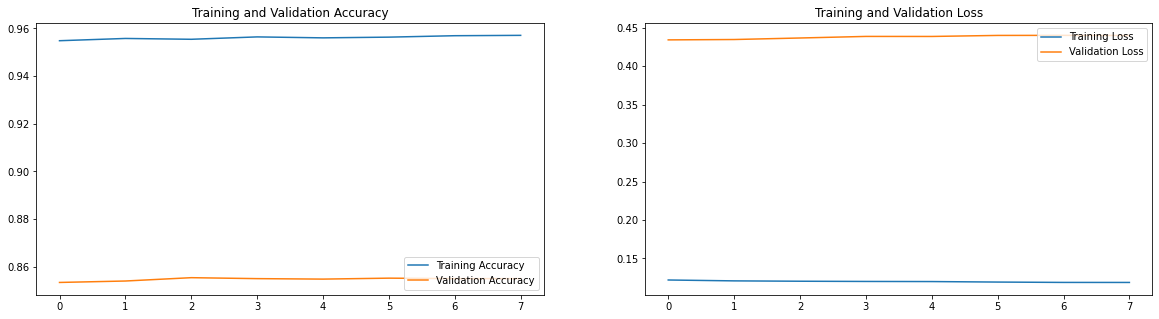

In [ ]:
# show loss and accuracy (Training, Validation)
def show_loss_accuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
show_loss_accuracy(history)

Since we have used the save best model callback,we have saved the model that have reached the maximum accuracy: 85.52%.
This Model will be used for making further prediction on other test datasets.